## 1 Import libraries

In [2]:
pip install wordcloud


   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/299.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/299.9 kB 487.6 kB/s eta 0:00:01
   ---------------- ----------------------- 122.9/299.9 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------  297.0/299.9 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 299.9/299.9 kB 1.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import eda_helper_functions
from sklearn.ensemble import IsolationForest

## read the training data

In [8]:
file_path=r"C:\Users\sr322\OneDrive\Desktop\fligh_price_predictor_aws\data\train.csv"

train=pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,08:55:00,19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,17:30:00,04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,11:40:00,14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,22:55:00,07:40:00,525,1.0,In-flight meal not included,11087
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-03-21,Delhi,Cochin,10:45:00,18:50:00,1925,2.0,No Info,11093
6691,Air India,2019-05-01,Kolkata,Banglore,09:25:00,18:30:00,545,1.0,No Info,8891
6692,Jet Airways,2019-06-01,Delhi,Cochin,14:00:00,19:00:00,300,1.0,In-flight meal not included,10262
6693,Air Asia,2019-06-24,Delhi,Cochin,07:55:00,13:25:00,330,1.0,No Info,6152


In [9]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [17]:
train=train.assign(**{
    col: pd.to_datetime(train.loc[:,col],dayfirst=True,format='mixed')
    for col in ['date_of_journey','dep_time','arrival_time']
}
)

train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

## 3 high level summary of data

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6695 non-null   object        
 1   date_of_journey  6695 non-null   datetime64[ns]
 2   source           6695 non-null   object        
 3   destination      6695 non-null   object        
 4   dep_time         6695 non-null   datetime64[ns]
 5   arrival_time     6695 non-null   datetime64[ns]
 6   duration         6695 non-null   int64         
 7   total_stops      6694 non-null   float64       
 8   additional_info  6695 non-null   object        
 9   price            6695 non-null   int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 523.2+ KB


In [21]:
train.describe(include='number')

,duration,total_stops,price
count,6695.000000,6694.000000,6695.000000
mean,633.489171,0.801464,9030.965646
std,503.006311,0.659737,4639.522857
min,75.000000,0.000000,1759.000000
25%,170.000000,0.000000,5224.000000
50%,510.000000,1.000000,8283.000000
75%,922.500000,1.000000,12373.000000
max,2860.000000,3.000000,62427.000000


In [23]:
train.describe(include='O')

,airline,source,destination,additional_info
count,6695,6695,6695,6695
unique,9,5,6,7
top,Jet Airways,Delhi,Cochin,No Info
freq,2391,2730,2730,5249


In [26]:
(
    train
    .assign(total_stops=train['total_stops'].astype(object))
    .describe(include="O")
    
)

,airline,source,destination,total_stops,additional_info
count,6695,6695,6695,6694.0,6695
unique,9,5,6,4.0,7
top,Jet Airways,Delhi,Cochin,1.0,No Info
freq,2391,2730,2730,3580.0,5249


## 4 high level analysis of missing values

In [51]:
eda_helper_functions.missing_info(train)

,count,percentage
variable,,


In [50]:
train=train.dropna()

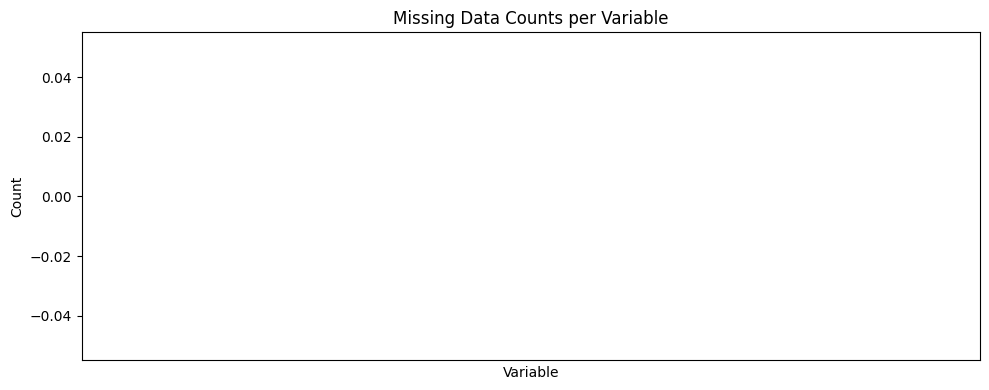

In [52]:
eda_helper_functions.plot_missing_info(train)

## 5 analysis of outlier

In [54]:
forest=IsolationForest(n_estimators=10,random_state=42)

In [58]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                       .drop(columns='price')
                                       .select_dtypes(include='number')))
    .query('outlier==-1')
    .duration
    .describe()
)

count    2824.000000
mean      871.683782
std       638.864664
min        75.000000
25%       150.000000
50%      1025.000000
75%      1425.000000
max      2860.000000
Name: duration, dtype: float64

## 6 pair plots

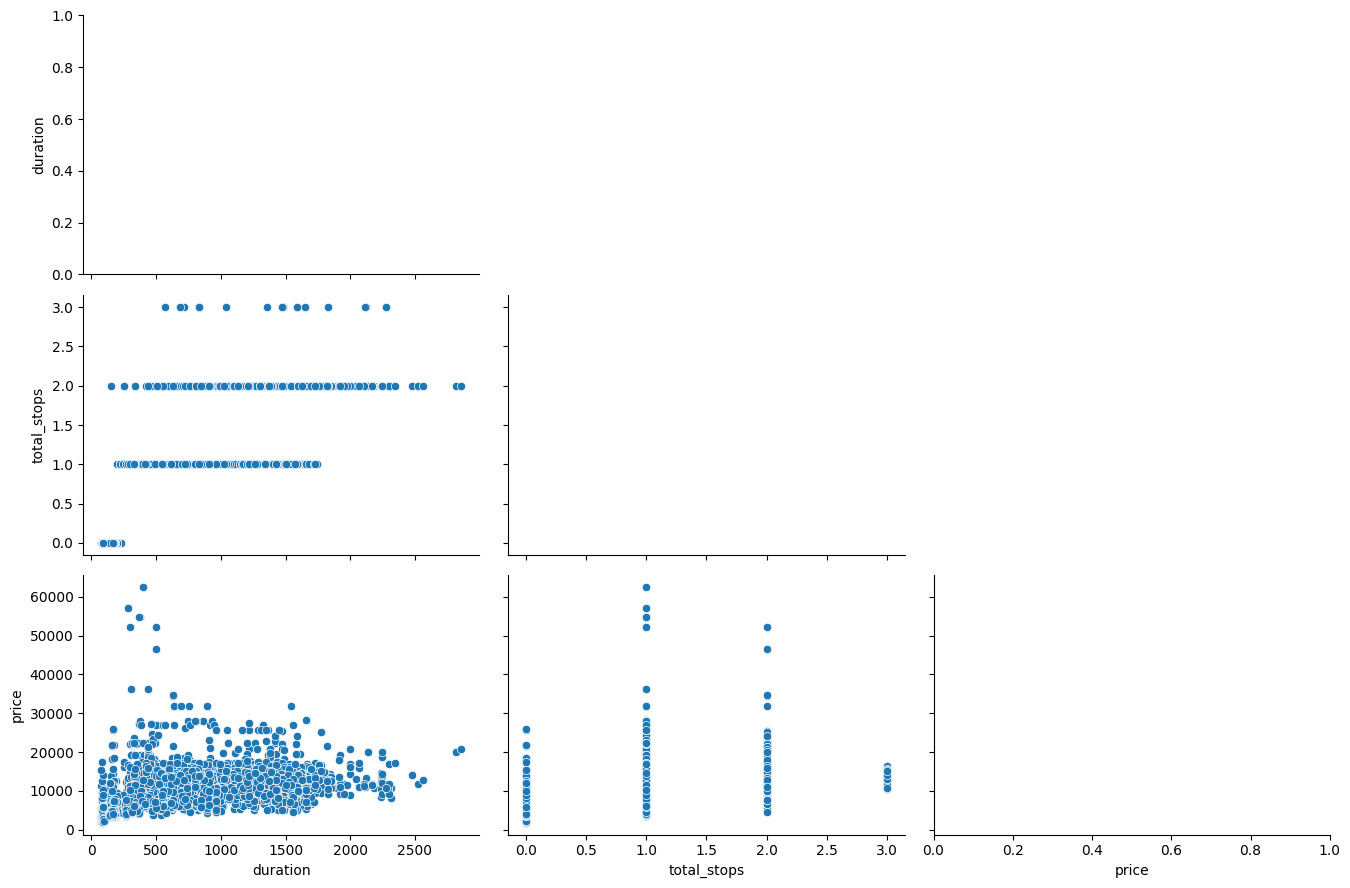

In [59]:
eda_helper_functions.pair_plots(train)

## correlation analysis

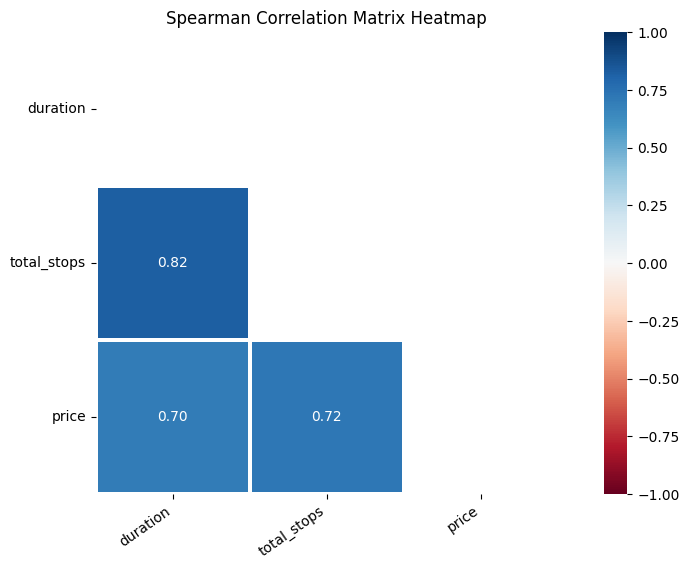

In [62]:
eda_helper_functions.correlation_heatmap(train)

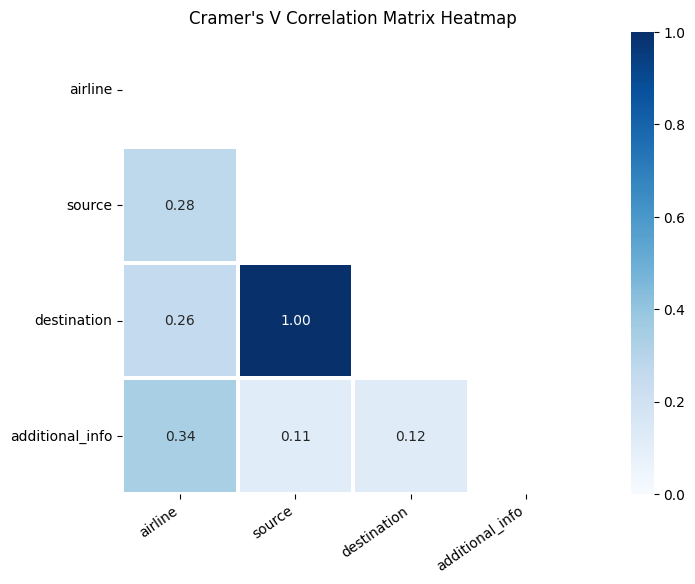

In [63]:
eda_helper_functions.cramersV_heatmap(train)

In [67]:
eda_helper_functions.get_iqr_outliers(train,'duration')

Lower Limit : -955.0
Upper Limit : 2045.0


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3690,Air India,2019-05-01,Kolkata,Banglore,2025-01-16 05:50:00,2025-01-16 16:15:00,2065,2.0,No Info,10991
6079,Jet Airways,2019-03-06,Delhi,Cochin,2025-01-16 17:55:00,2025-01-16 04:25:00,2070,2.0,No Info,17072
3225,Jet Airways,2019-03-06,Delhi,Cochin,2025-01-16 17:55:00,2025-01-16 04:25:00,2070,2.0,In-flight meal not included,15812
2990,Air India,2019-03-03,Banglore,New Delhi,2025-01-16 11:05:00,2025-01-16 22:10:00,2105,2.0,No Info,11791
4589,Air India,2019-03-18,Banglore,New Delhi,2025-01-16 11:05:00,2025-01-16 22:10:00,2105,2.0,No Info,11161
1517,Air India,2019-03-03,Banglore,New Delhi,2025-01-16 11:05:00,2025-01-16 22:10:00,2105,2.0,No Info,11948
2916,Air India,2019-05-12,Kolkata,Banglore,2025-01-16 12:00:00,2025-01-16 23:15:00,2115,3.0,No Info,10991
2170,Air India,2019-03-12,Banglore,New Delhi,2025-01-16 06:45:00,2025-01-16 18:05:00,2120,3.0,No Info,13387
1105,Jet Airways,2019-03-06,Delhi,Cochin,2025-01-16 16:50:00,2025-01-16 04:25:00,2135,2.0,No Info,19907
4000,Air India,2019-03-06,Delhi,Cochin,2025-01-16 07:05:00,2025-01-16 19:15:00,2170,2.0,No Info,11552


## 8 Detailed Analysis

In [68]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

### 8.1 airlne

In [69]:
train.airline

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6694, dtype: object

In [70]:
eda_helper_functions.cat_summary(train,'airline')

0       Jet Airways
1       Jet Airways
2             Goair
3         Air India
4       Jet Airways
           ...     
6690    Jet Airways
6691      Air India
6692    Jet Airways
6693       Air Asia
6694      Air India
Name: airline, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 9 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,9
top,Jet Airways
freq,2391


,count,percentage
category,,
Jet Airways,2391,0.357186
Indigo,1296,0.193606
Air India,1075,0.160592
Multiple Carriers,736,0.109949
Spicejet,537,0.080221
Vistara,322,0.048103
Air Asia,211,0.031521
Goair,125,0.018673
Trujet,1,0.000149


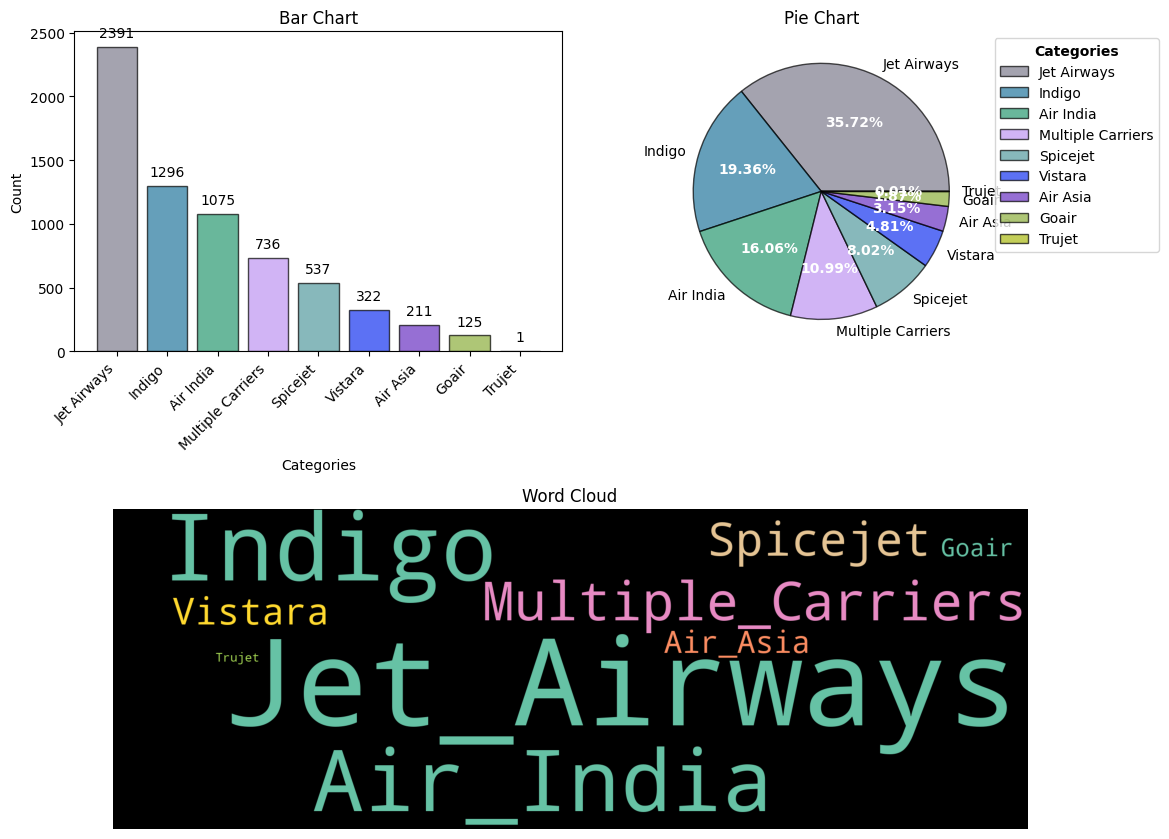

In [71]:
eda_helper_functions.cat_univar_plots(train, "airline")


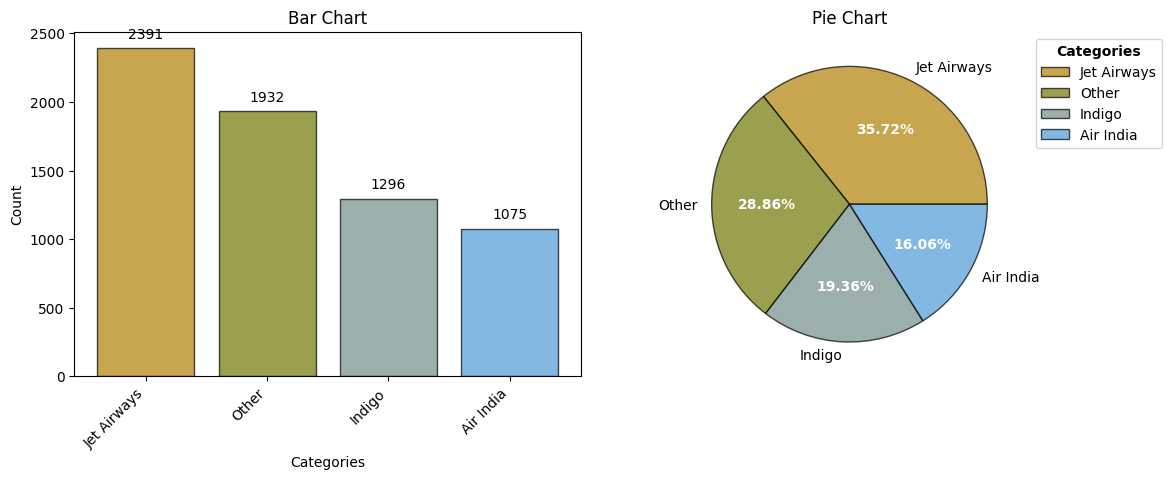

In [72]:
eda_helper_functions.cat_univar_plots(train, "airline", show_wordcloud=False, k=3)


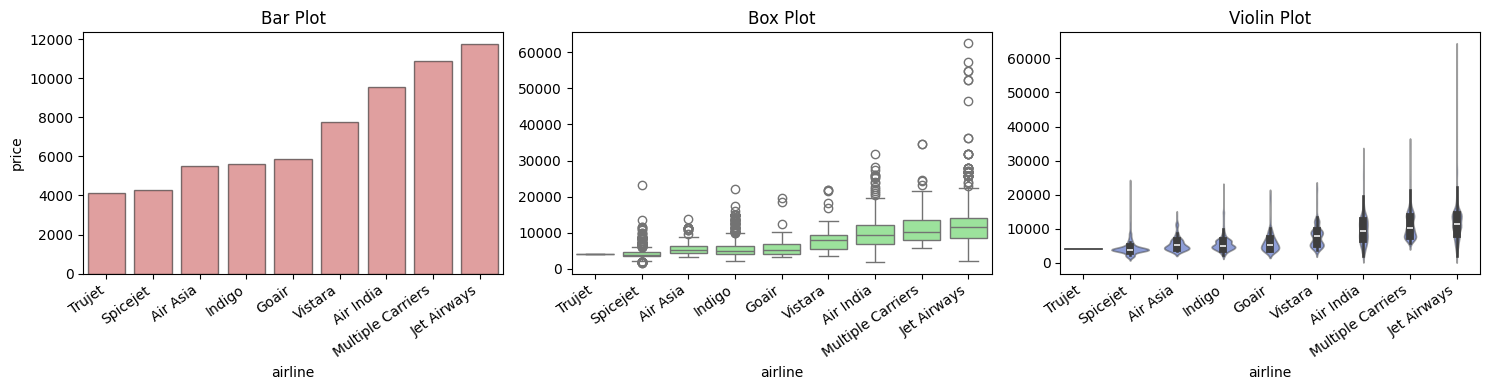

In [73]:
eda_helper_functions.num_cat_bivar_plots(
	data=train,
	num_var="price",
	cat_var="airline"
)

In [74]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 473.2504388077414
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 3130.947388921903
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


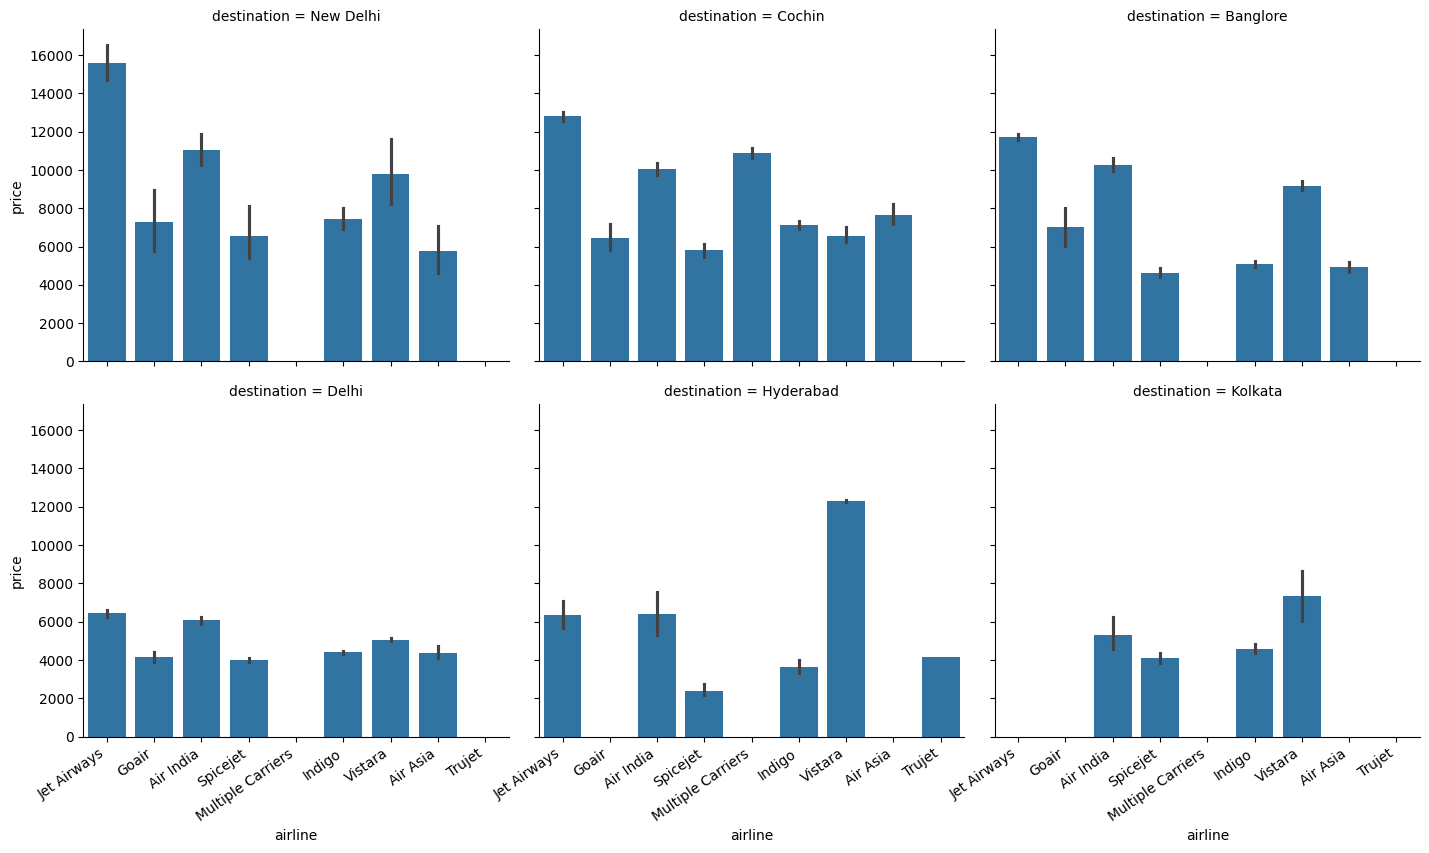

In [75]:
airline_grid = sns.FacetGrid(
	data=train,
	col="destination",
	col_wrap=3,
	height=4,
	aspect=1.2,
	sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
	eda_helper_functions.rotate_xlabels(ax)

### 8.2 date_of_journey

In [81]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-21,Banglore,New Delhi,2025-01-16 08:55:00,2025-01-16 19:10:00,615,1.0,In-flight meal not included,7832
1,Jet Airways,2019-03-27,Delhi,Cochin,2025-01-16 17:30:00,2025-01-16 04:25:00,655,1.0,In-flight meal not included,6540
2,Goair,2019-03-09,Banglore,New Delhi,2025-01-16 11:40:00,2025-01-16 14:35:00,175,0.0,No Info,7305
3,Air India,2019-06-12,Kolkata,Banglore,2025-01-16 09:25:00,2025-01-16 18:30:00,545,1.0,No Info,8366
4,Jet Airways,2019-03-12,Banglore,New Delhi,2025-01-16 22:55:00,2025-01-16 07:40:00,525,1.0,In-flight meal not included,11087


In [97]:
train.drop(columns=['months'],inplace=True)

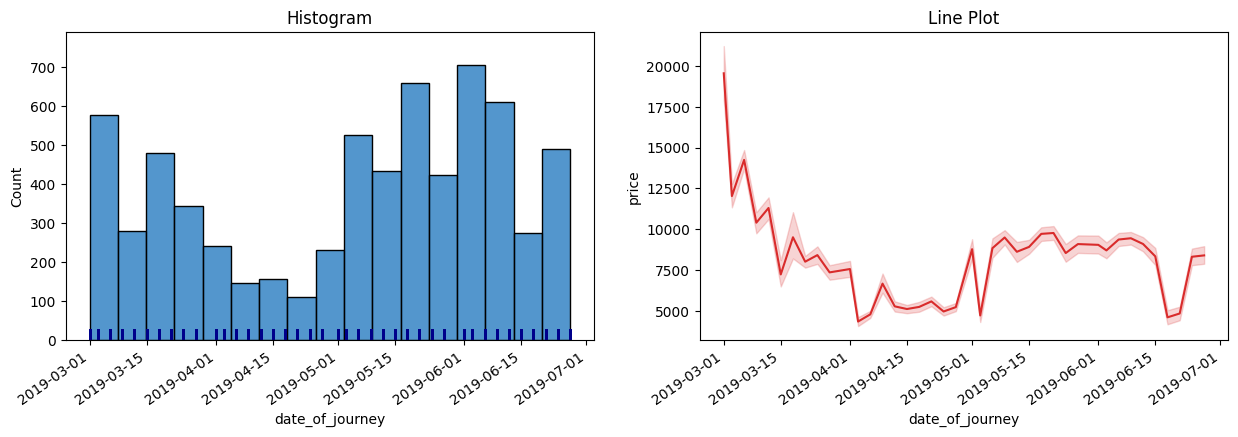

In [77]:
eda_helper_functions.dt_univar_plots(
	data=train,
	var="date_of_journey",
	target="price"
)

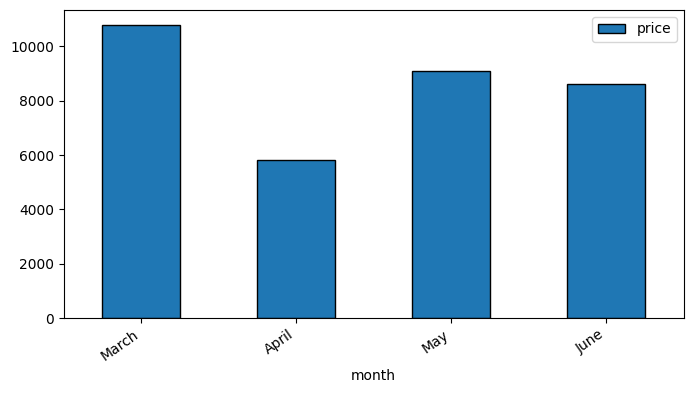

In [78]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="M"))
	.price.mean()
	.to_frame()
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

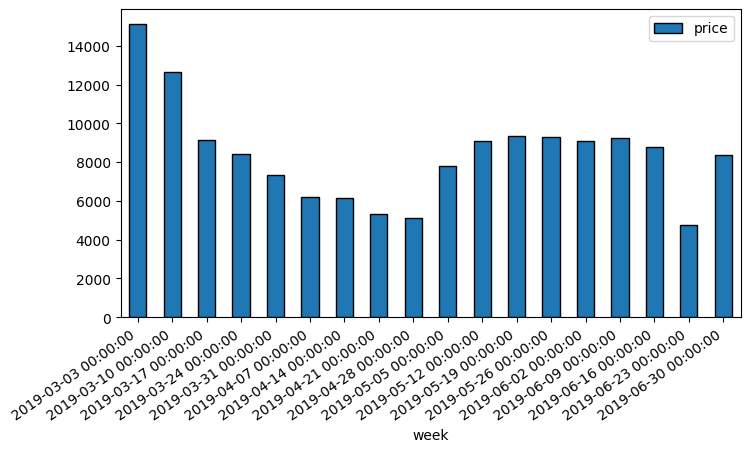

In [79]:
(
	train
	.groupby(pd.Grouper(key="date_of_journey", freq="W"))
	.price.mean()
	.to_frame()
	.rename_axis(index="week")
	.plot(
		kind="bar",
		figsize=(8, 4),
		edgecolor="black"
	)
)

ax = plt.gca()
eda_helper_functions.rotate_xlabels(ax)

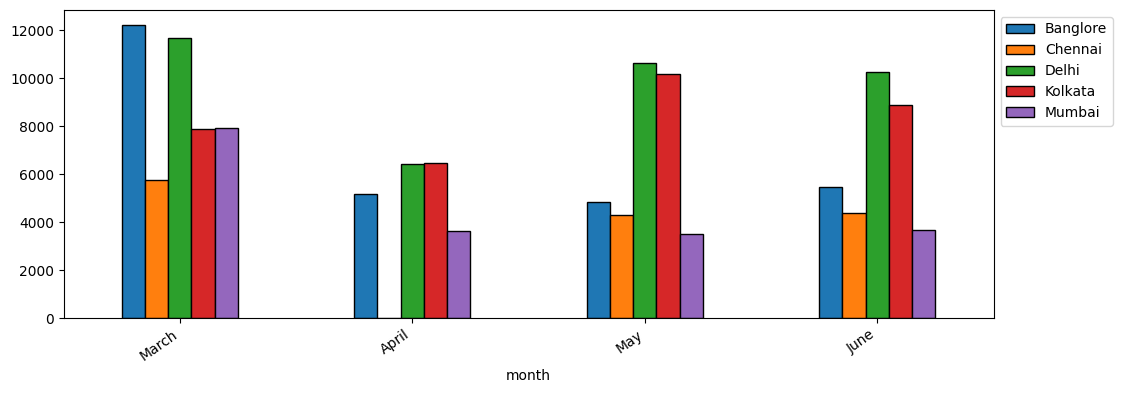

In [80]:
(
	train
	.groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
	.price.mean()
	.unstack(fill_value=0)
	.set_axis(["March", "April", "May", "June"], axis=0)
	.rename_axis(index="month")
	.plot(
		kind="bar",
		figsize=(12, 4),
		edgecolor="black"
	)
)

ax = plt.gca()

ax.legend(
	loc="upper left",
	bbox_to_anchor=(1, 1)
)

eda_helper_functions.rotate_xlabels(ax)

### 8.3 dep_time

In [95]:
train.dep_time


0      2025-01-16 08:55:00
1      2025-01-16 17:30:00
2      2025-01-16 11:40:00
3      2025-01-16 09:25:00
4      2025-01-16 22:55:00
               ...        
6690   2025-01-16 10:45:00
6691   2025-01-16 09:25:00
6692   2025-01-16 14:00:00
6693   2025-01-16 07:55:00
6694   2025-01-16 11:50:00
Name: dep_time, Length: 6694, dtype: datetime64[ns]

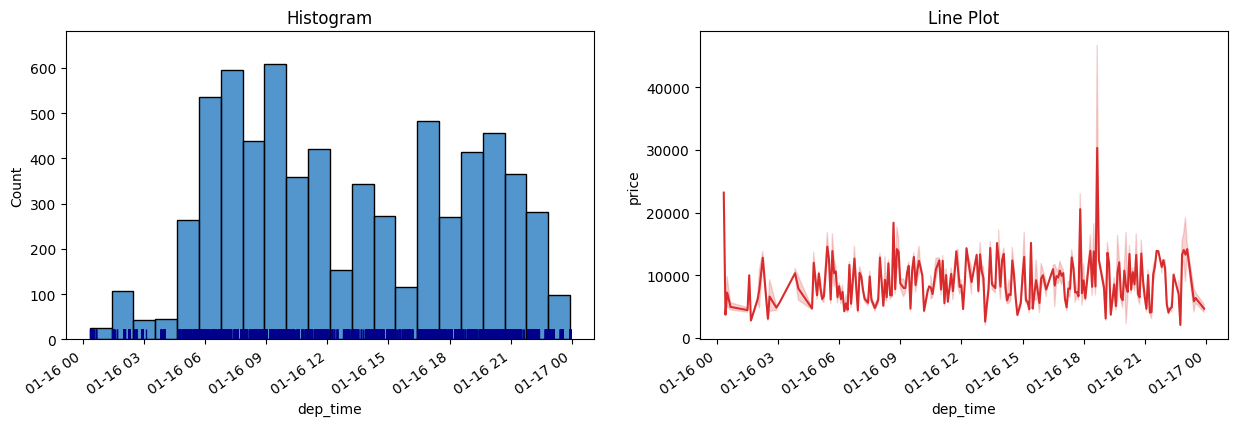

In [98]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")


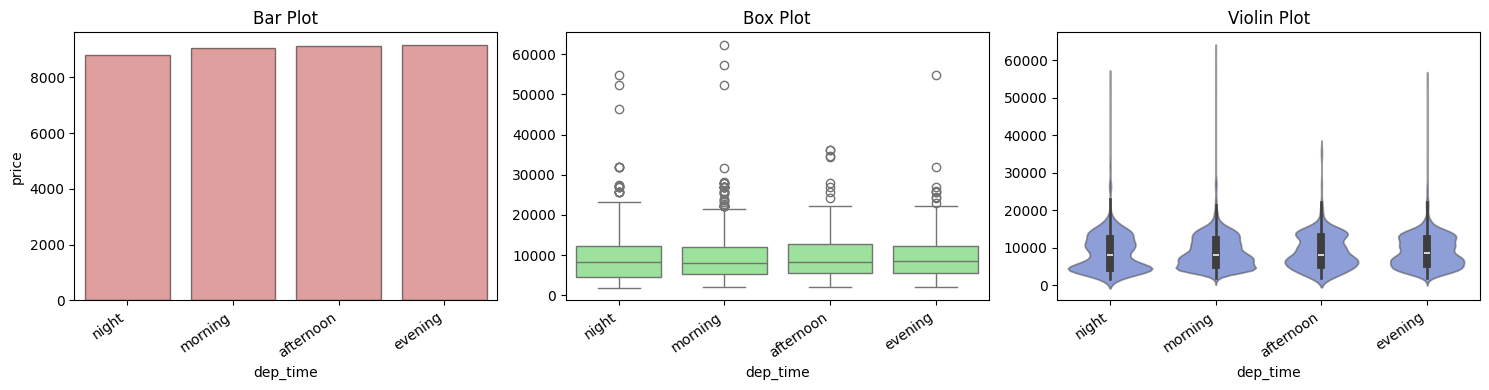

In [99]:
(
	train
	.assign(dep_time=lambda df_: (
		np.select([df_.dep_time.dt.hour.between(4, 12, inclusive="left"),
				   df_.dep_time.dt.hour.between(12, 16, inclusive="left"),
				   df_.dep_time.dt.hour.between(16, 20, inclusive="left")],
				  ["morning", "afternoon", "evening"],
				  default="night")
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")
)

### duration

In [101]:
train.duration

0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6694, dtype: int64

In [102]:
eda_helper_functions.num_summary(train, "duration")


0        615
1        655
2        175
3        545
4        525
        ... 
6690    1925
6691     545
6692     300
6693     330
6694    1265
Name: duration, Length: 6694, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,170.00
50,510.00
75,920.00
90,1440.00
95,1601.75
99,1855.00


,value
mean,633.371676
trimmed mean (5%),599.575174
trimmed mean (10%),570.895258
median,510.000000


,value
var,252960.712875
std,502.951999
IQR,750.000000
mad,340.000000
coef_variance,0.794087


,value
skewness,0.894131
kurtosis,-0.052204


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 7.367044778597017e-57
Test Statistic       : 0.886539636636061
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.787
Test Statistic       : 248.45769626661695
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


In [103]:
train.duration.quantile([0.25, 0.5, 0.75])


0.25    170.0
0.50    510.0
0.75    920.0
Name: duration, dtype: float64

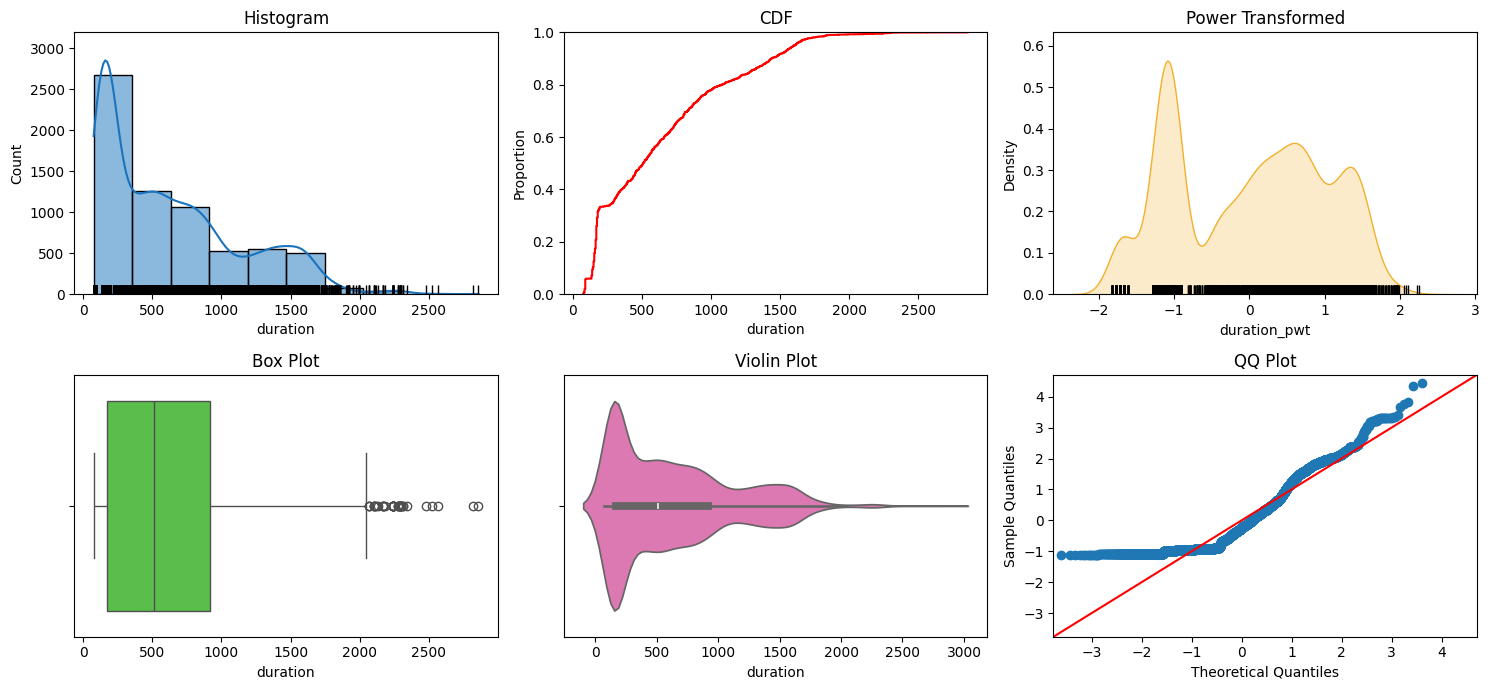

In [104]:
eda_helper_functions.num_univar_plots(train, "duration")


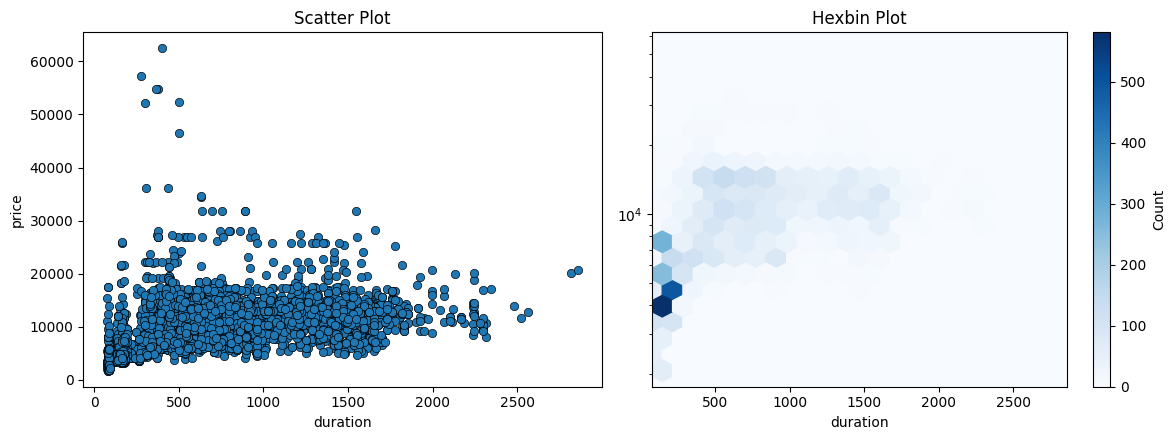

In [105]:
eda_helper_functions.num_bivar_plots(
	train,
	"duration",
	"price",
	hexbin_kwargs=dict(
		yscale="log",
		gridsize=20,
		cmap="Blues"
	)
)

In [106]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.5091878071906593
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6980000420004595
- p-value              : 0.0
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


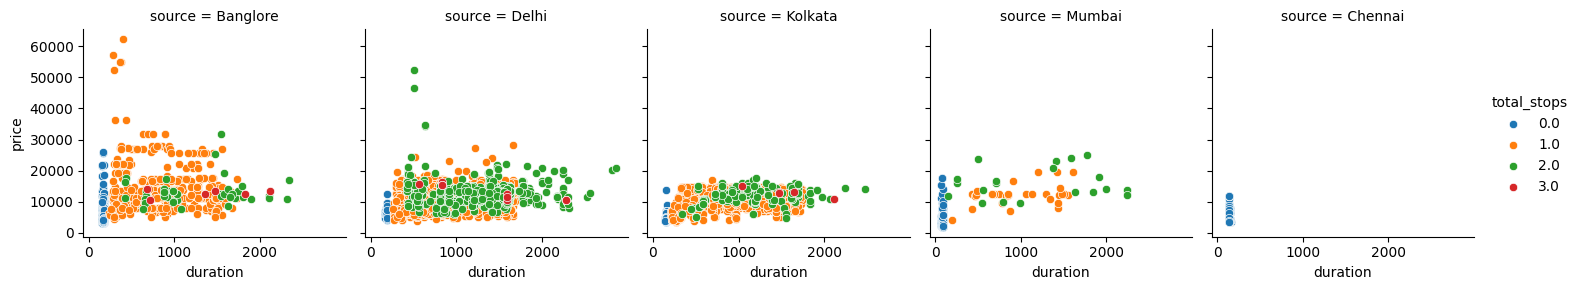

In [107]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

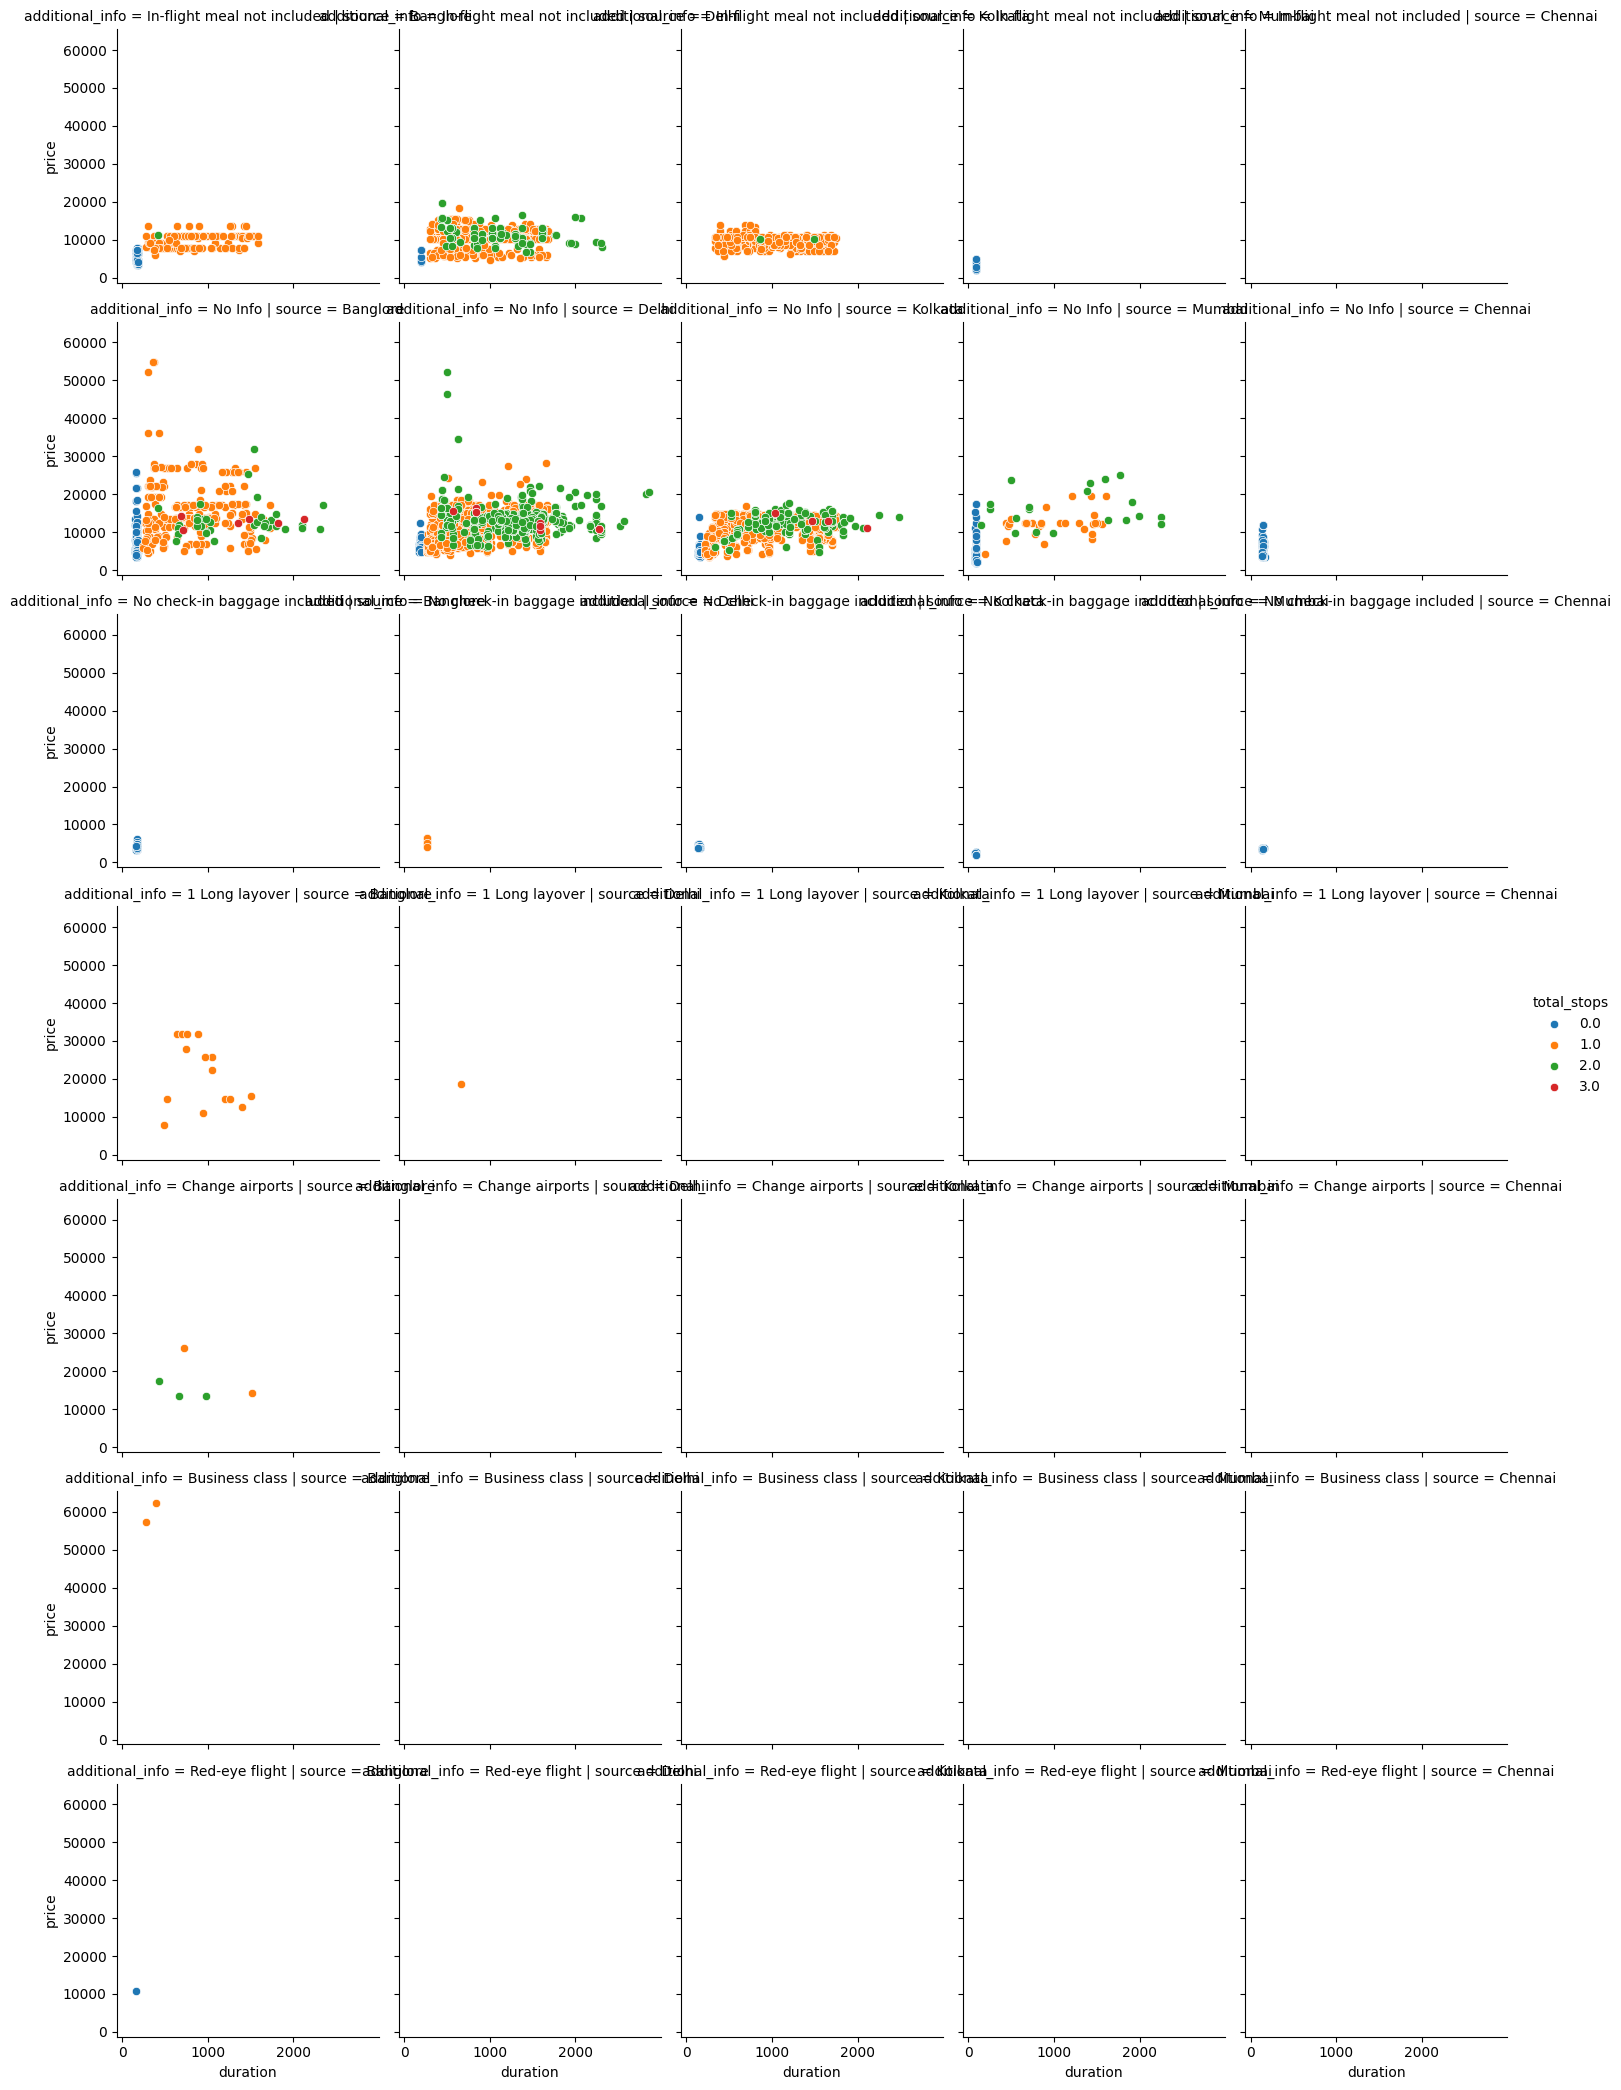

In [109]:
duration_grid = sns.FacetGrid(
	data=train,
	col="source",
	row="additional_info",
	hue="total_stops",
	sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [110]:
eda_helper_functions.get_iqr_outliers(train, "duration")


Lower Limit : -955.0
Upper Limit : 2045.0


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
3690,Air India,2019-05-01,Kolkata,Banglore,2025-01-16 05:50:00,2025-01-16 16:15:00,2065,2.0,No Info,10991
6079,Jet Airways,2019-03-06,Delhi,Cochin,2025-01-16 17:55:00,2025-01-16 04:25:00,2070,2.0,No Info,17072
3225,Jet Airways,2019-03-06,Delhi,Cochin,2025-01-16 17:55:00,2025-01-16 04:25:00,2070,2.0,In-flight meal not included,15812
2990,Air India,2019-03-03,Banglore,New Delhi,2025-01-16 11:05:00,2025-01-16 22:10:00,2105,2.0,No Info,11791
4589,Air India,2019-03-18,Banglore,New Delhi,2025-01-16 11:05:00,2025-01-16 22:10:00,2105,2.0,No Info,11161
1517,Air India,2019-03-03,Banglore,New Delhi,2025-01-16 11:05:00,2025-01-16 22:10:00,2105,2.0,No Info,11948
2916,Air India,2019-05-12,Kolkata,Banglore,2025-01-16 12:00:00,2025-01-16 23:15:00,2115,3.0,No Info,10991
2170,Air India,2019-03-12,Banglore,New Delhi,2025-01-16 06:45:00,2025-01-16 18:05:00,2120,3.0,No Info,13387
1105,Jet Airways,2019-03-06,Delhi,Cochin,2025-01-16 16:50:00,2025-01-16 04:25:00,2135,2.0,No Info,19907
4000,Air India,2019-03-06,Delhi,Cochin,2025-01-16 07:05:00,2025-01-16 19:15:00,2170,2.0,No Info,11552


### additional_info

In [111]:
eda_helper_functions.cat_summary(train, "additional_info")


0       In-flight meal not included
1       In-flight meal not included
2                           No Info
3                           No Info
4       In-flight meal not included
                   ...             
6690                        No Info
6691                        No Info
6692    In-flight meal not included
6693                        No Info
6694                 1 Long layover
Name: additional_info, Length: 6694, dtype: object

Data Type      : object
Cardinality    : 7 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 6,694 / 6,694 rows


,
count,6694
unique,7
top,No Info
freq,5248


,count,percentage
category,,
No Info,5248,0.783986
In-flight meal not included,1215,0.181506
No check-in baggage included,207,0.030923
1 Long layover,16,0.002390
Change airports,5,0.000747
Business class,2,0.000299
Red-eye flight,1,0.000149


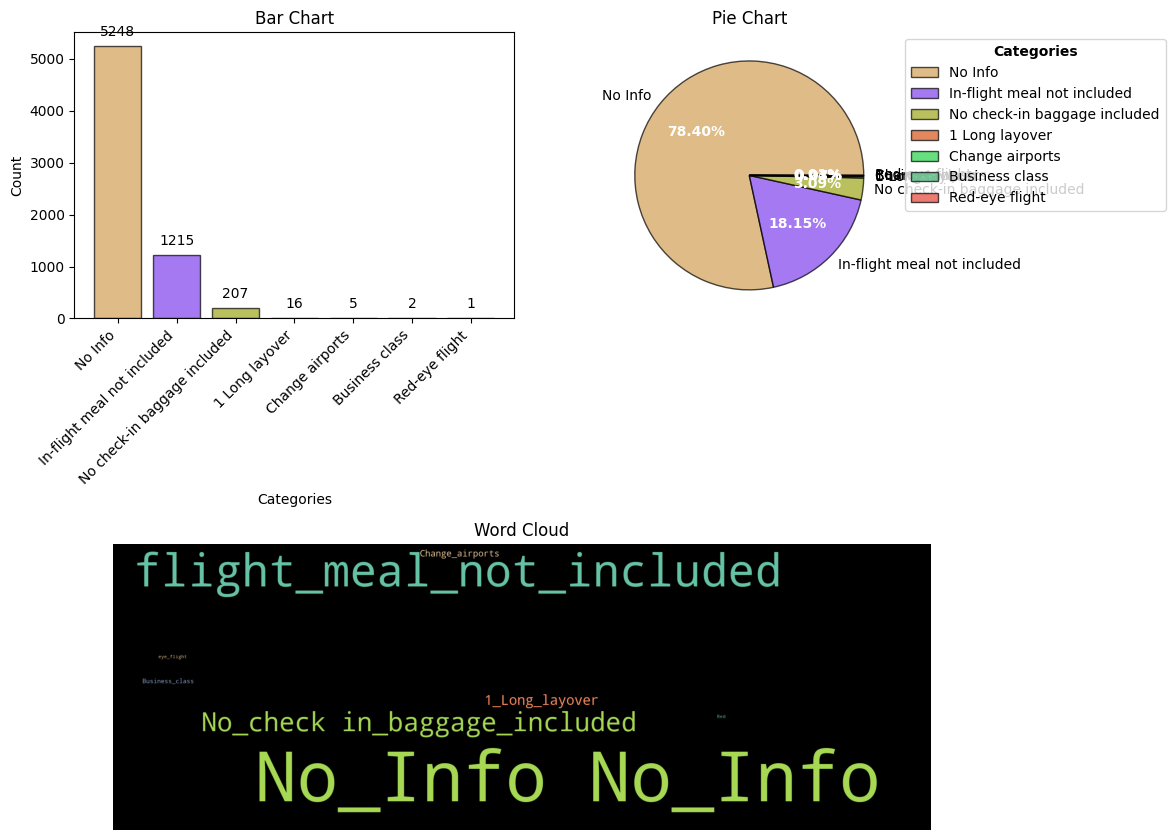

In [112]:
eda_helper_functions.cat_univar_plots(train, "additional_info")


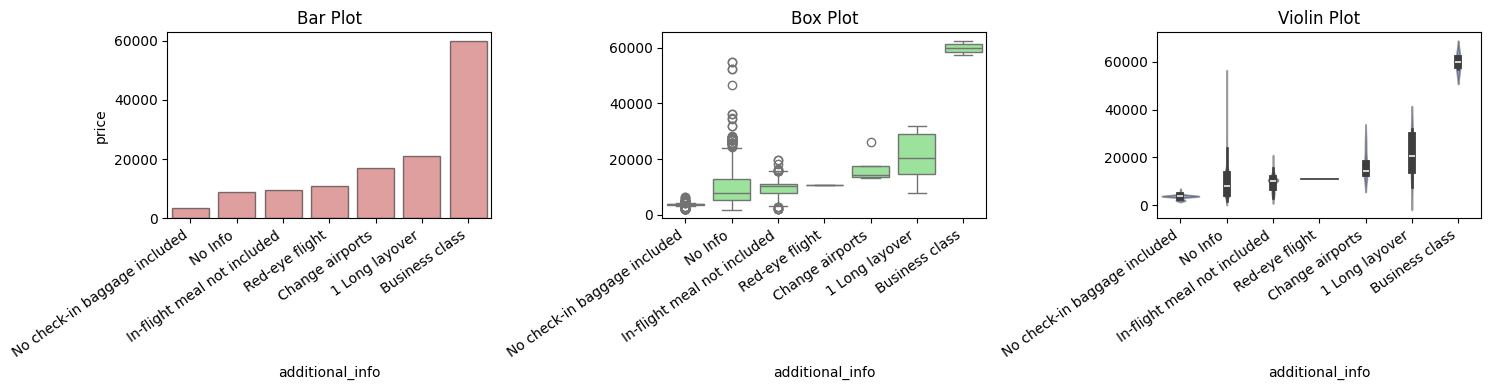

In [113]:
eda_helper_functions.num_cat_bivar_plots(train, "price", "additional_info")


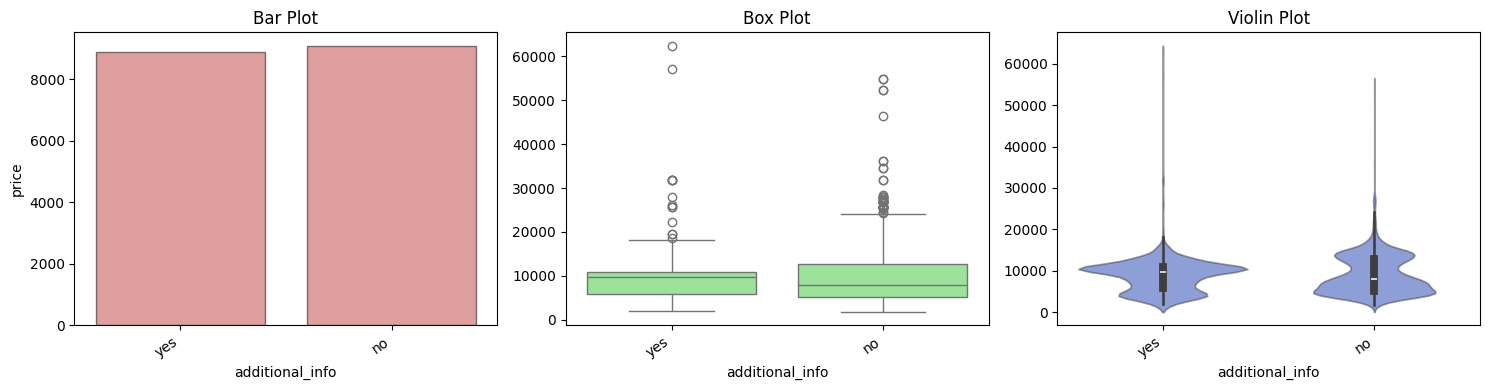

In [114]:
# convertion additional_info into a binary feature for analysis

(
	train
	.assign(additional_info=(
		train
		.additional_info
		.pipe(lambda ser: np.where(ser.eq("No Info"), "no", "yes"))
	))
	.pipe(eda_helper_functions.num_cat_bivar_plots, "price", "additional_info")
)